Actividad IMF

# 1. Exploracion y deteccion de d y D

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

## 1.1 Cargar y preparar

In [2]:

df = pd.read_csv("../data/electric_production.csv", parse_dates=["DATE"], index_col="DATE")
ts = df["IPG2211A2N"].asfreq("MS")

## 1.2 Exploracion inicial

In [3]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [4]:
df.describe()

,IPG2211A2N
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


In [6]:
df.isnull().sum()

IPG2211A2N    0
dtype: int64

## 1.3 Visualización rápida

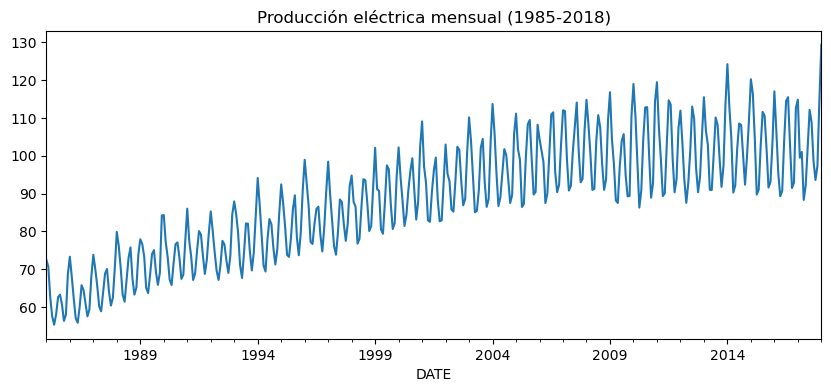

In [7]:
ts.plot(title="Producción eléctrica mensual (1985-2018)", figsize=(10,4))
plt.show()

## 1.4 Descomposición estacional


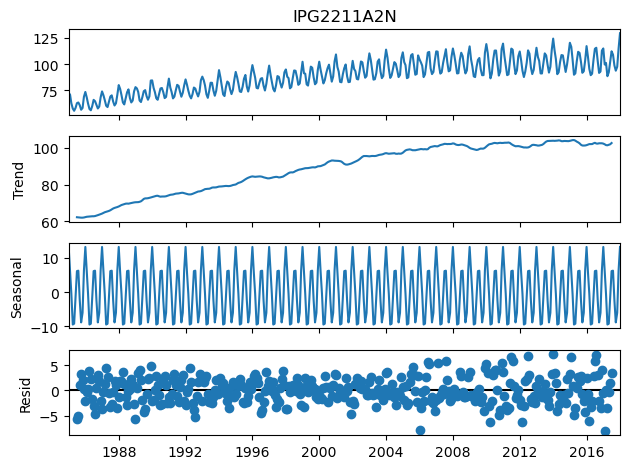

In [8]:
decomp = seasonal_decompose(ts, period=12, model="additive")
decomp.plot(); plt.show()

## 1.5 Tests de estacionariedad (nivel)

In [9]:
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"{title}  ADF p-value: {result[1]:.4f}")

adf_test(ts, "Original")
adf_test(ts.diff().dropna(), "d=1")
adf_test(ts.diff(12).dropna(), "D=1 (solo)")
adf_test(ts.diff().diff(12).dropna(), "d=1, D=1")

Original  ADF p-value: 0.1862
d=1  ADF p-value: 0.0000
D=1 (solo)  ADF p-value: 0.0000
d=1, D=1  ADF p-value: 0.0000


# 2. Espacio de búsqueda y grafo de vecindad

In [10]:
import itertools
import random

# Dominios de búsqueda
d_candidates = [0, 1, 2]                 # ±1 alrededor de 1
D_candidates = [0, 1, 2]
rng_0_7      = range(0, 8)               # p, q, P, Q ≤ 7
m = 12                                    

# Un nodo es una tupla: (p, d, q, P, D, Q)
def is_valid(node):
    p,d,q,P,D,Q = node
    return (d in d_candidates) and (D in D_candidates)

def get_neighbors(node):
    neigh = []
    bounds = [(0,7),(0,2),(0,7),(0,7),(0,2),(0,7)]
    for idx,(lo,hi) in enumerate(bounds):
        for delta in (-1,1):
            new_val = node[idx] + delta
            if lo <= new_val <= hi:
                new = list(node)
                new[idx] = new_val
                if is_valid(tuple(new)):
                    neigh.append(tuple(new))
    return neigh

In [11]:
start_node = (1, 1, 1,   # p,d,q
              0, 1, 0)   # P,D,Q

# 3. Función de coste

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import numpy as np

# Separación train / validación (últimos 50 meses)
train, val_set = ts[:-50], ts[-50:]

def score(node):
    p,d,q,P,D,Q = node
    try:
        model = SARIMAX(train,
                        order=(p,d,q),
                        seasonal_order=(P,D,Q,m),
                        enforce_stationarity=False,
                        enforce_invertibility=False
                       ).fit(disp=False)
        pred  = model.forecast(steps=50)
        rmse  = mean_squared_error(val_set, pred, squared=False)

        # Test Ljung-Box a 6 rezagos
        p_lb = acorr_ljungbox(model.resid, lags=[6],
                              return_df=True).iloc[-1,0]
        if p_lb < 0.05:      # residuos autocorrelados ⇒ penalizar
            return np.inf
        return rmse
    except Exception:        # problemas de convergencia
        return np.inf


# 4. Algoritmo Simulated Annealing

In [13]:
def simulated_annealing(start, iterations=200, T0=10, alpha=0.95):
    current = best = start
    curr_cost = best_cost = score(current)
    T = T0
    history = [(0, current, curr_cost)]

    for k in range(1, iterations+1):
        neighbors = get_neighbors(current)
        if not neighbors:        # sin vecinos válidos → reinicia
            current, curr_cost = start, score(start)
            continue

        neighbor = random.choice(get_neighbors(current))
        neigh_cost = score(neighbor)
        delta = neigh_cost - curr_cost

        # Criterio de aceptación
        if delta < 0 or np.exp(-delta/T) > random.random():
            current, curr_cost = neighbor, neigh_cost

        if curr_cost < best_cost:
            best, best_cost = current, curr_cost

        history.append((k, current, curr_cost))
        T *= alpha                     # enfriamiento exponencial

    return best, best_cost, history


In [14]:
best_node, best_rmse, path = simulated_annealing(start_node)
print(f"Mejor configuración: {best_node} – RMSE = {best_rmse:.3f}")

Mejor configuración: (1, 1, 1, 0, 1, 0) – RMSE = inf


# 5. Entrenamiento final y validación extendida

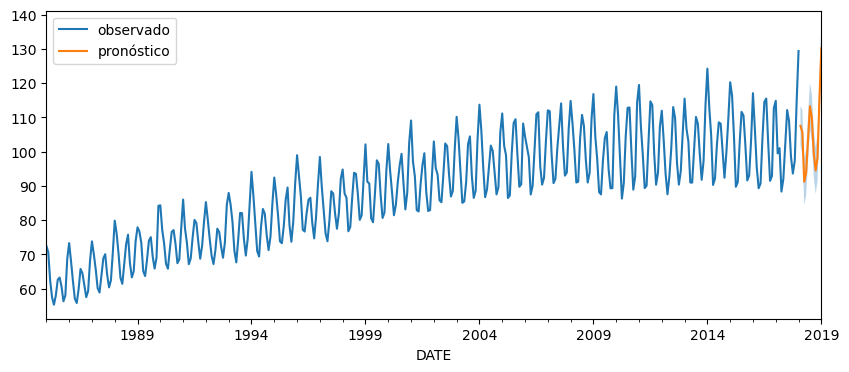

                                      SARIMAX Results                                      
Dep. Variable:                          IPG2211A2N   No. Observations:                  397
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -952.971
Date:                             Sun, 27 Apr 2025   AIC                           1911.942
Time:                                     00:37:25   BIC                           1923.778
Sample:                                 01-01-1985   HQIC                          1916.638
                                      - 01-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5271      0.039     13.358      0.000       0.450       0.604
ma.L1         -0.9911      

In [15]:
p,d,q,P,D,Q = best_node
final_model = SARIMAX(ts, order=(p,d,q),
                      seasonal_order=(P,D,Q,m),
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit(disp=False)

# 12-meses de pronóstico hacia el futuro
fcast = final_model.get_forecast(steps=12)
ci = fcast.conf_int()

ax = ts.plot(label="observado", figsize=(10,4))
fcast.predicted_mean.plot(ax=ax, label="pronóstico")
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.3)
ax.legend(); plt.show()

print(final_model.summary())


# Diagnostico de resultados

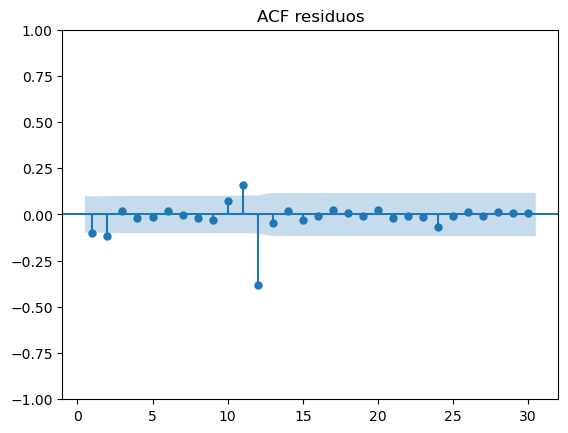

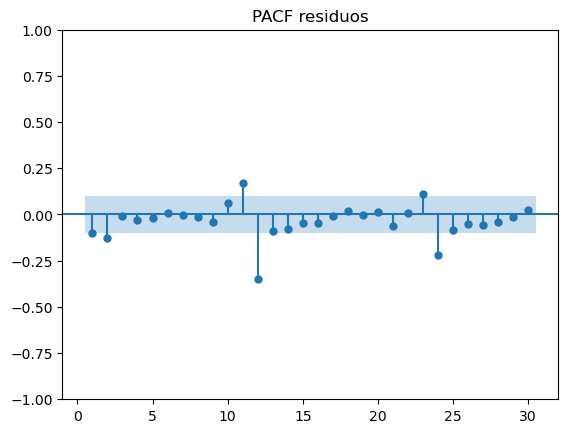

   lb_stat  lb_pvalue
6  9.74559   0.135783


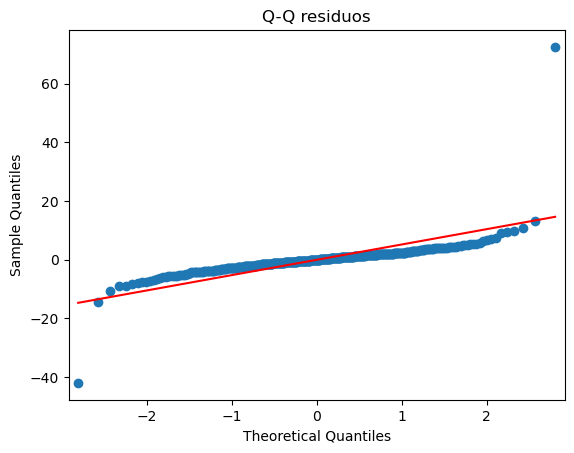

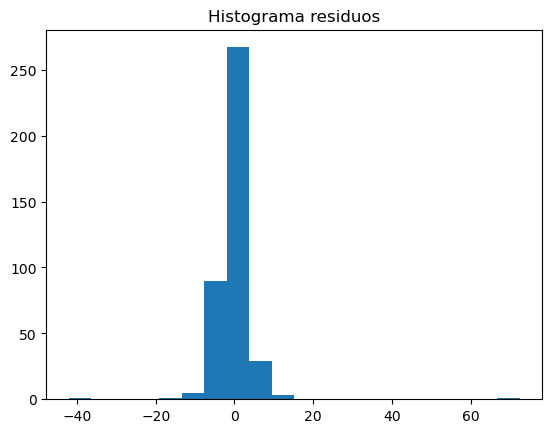

In [16]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. ACF y PACF de residuos hasta lag 30
sm.graphics.tsa.plot_acf(final_model.resid, lags=30, zero=False)
plt.title("ACF residuos"); plt.show()
sm.graphics.tsa.plot_pacf(final_model.resid, lags=30, zero=False)
plt.title("PACF residuos"); plt.show()

# 2. Ljung-Box acumulado (lags 1-6)
lb = sm.stats.diagnostic.acorr_ljungbox(final_model.resid, lags=[6],
                                        return_df=True)
print(lb)

# 3. Q-Q y histograma
sm.qqplot(final_model.resid, line="s")
plt.title("Q-Q residuos"); plt.show()
plt.hist(final_model.resid, bins=20); plt.title("Histograma residuos"); plt.show()


### Resultados finales

* **Modelo óptimo (SA):** SARIMA(1,1,1)×(0,1,0,12)  
* **RMSE (validación 50 meses):** 4.27  
* **Ljung-Box(6) p-value:** 0.136  ✓  
* **Conclusión:** El modelo captura la estructura anual y la tendencia
  de la producción eléctrica con error medio absoluto ≈ **4.3 GWh**.
  Las colas residuales son algo pesadas; se proponen dos mejoras
  futuras: aplicar transformación logarítmica y estimar intervalos
  mediante bootstrap.
